# Segmentación

Ya hemos aprendido sobre la Detección de Objetos, que nos permite localizar objetos en la imagen prediciendo sus *cajas delimitadoras*. Sin embargo, para algunas tareas no solo necesitamos cajas delimitadoras, sino también una localización más precisa de los objetos. Esta tarea se llama **segmentación**.

La segmentación puede verse como **clasificación de píxeles**, donde para **cada** píxel de la imagen debemos predecir su clase (*fondo* siendo una de las clases). Hay dos algoritmos principales de segmentación:

* **Segmentación semántica** solo indica la clase del píxel, y no hace una distinción entre diferentes objetos de la misma clase.
* **Segmentación de instancias** divide las clases en diferentes instancias.

Por ejemplo, en la segmentación de instancias, 10 ovejas son objetos diferentes, mientras que en la segmentación semántica, todas las ovejas son representadas por una única clase.

![Instance vs semantic](https://drive.google.com/uc?export=view&id=1f_PPSgGbZyRlHtVMMqyVn8PFmt01Zycl)

> Imagen de [este blog](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)

Existen diferentes arquitecturas neuronales para la segmentación, pero todas tienen la misma estructura:

* **Encoder** extrae características de la imagen de entrada.
* **Decoder** transforma esas características en la **imagen de máscara**, con el mismo tamaño y número de canales correspondientes al número de clases.

![Instance vs semantic](https://drive.google.com/uc?export=view&id=1VgCVwV0T7WeZ0A2c8Q3BbKoTnS9uZbtT)

> Imagen de [esta publicación](https://arxiv.org/pdf/2001.05566.pdf)



## Prerrequisitos

Para comenzar, importaremos las bibliotecas necesarias y verificaremos si hay una GPU disponible para el entrenamiento.


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 32
epochs = 30

## El Conjunto de Datos

Utilizaremos la <a href="https://www.fc.up.pt/addi/ph2%20database.html">Base de Datos PH<sup>2</sup></a> de imágenes de dermatoscopia de nevos humanos. Este conjunto de datos contiene 200 imágenes de tres clases: nevus típico, nevus atípico y melanoma. Todas las imágenes también contienen la **máscara** correspondiente que delinea el nevus.

El código a continuación descarga el conjunto de datos desde su ubicación original y lo descomprime. Necesitarás tener instalada la utilidad `unrar` para que este código funcione; puedes instalarla utilizando `sudo apt-get install unrar` en Linux, o descargando la versión de línea de comandos para Windows [aquí](https://www.rarlab.com/rar_add.htm).


In [3]:
#!apt-get install rar
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar

--2024-09-09 02:11:55--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/epzcoqeyr1v9qlv/PH2Dataset.rar?rlkey=6mt2jlvwfkditkyg12xdei6ux [following]
--2024-09-09 02:11:55--  https://www.dropbox.com/scl/fi/epzcoqeyr1v9qlv/PH2Dataset.rar?rlkey=6mt2jlvwfkditkyg12xdei6ux
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc784143727db08265e7d013bd97.dl.dropboxusercontent.com/cd/0/inline/CaMds1cSpYePH53hdGeWitmxMN472iYm63kFMbZE7oducI99ypX4UPZezLYpTXFWwlV62a6N6hz7bTOrQXR4bd64VZA1p38OGbSEOKpS5Dt7ndEqK-z5WQoO2heaIsF7KV0/file# [following]
--2024-09-09 02:11:56--  https://uc784143727db08265e7d013bd97.dl.dropboxusercontent.com/cd/0/inline/CaMds1cSpYePH53hdGeWitmxMN47

Ahora definiremos el código para cargar el conjunto de datos. Transformaremos todas las imágenes al tamaño de 256x256 y dividiremos el conjunto de datos en una parte de entrenamiento y una parte de prueba. Esta función devuelve los conjuntos de datos de entrenamiento y prueba, cada uno conteniendo las imágenes originales y las máscaras que delinean el nevus.


In [4]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = torch.permute(torch.FloatTensor(np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])), (0, 3, 1, 2))
    masks = torch.FloatTensor(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks])).unsqueeze(1)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    train_dataset = (images[train_ind, :, :, :], masks[train_ind, :, :, :])
    test_dataset = (images[test_ind, :, :, :], masks[test_ind, :, :, :])

    return train_dataset, test_dataset

train_dataset, test_dataset = load_dataset(train_size)

Ahora vamos a graficar algunas de las imágenes del conjunto de datos para ver cómo se ven:


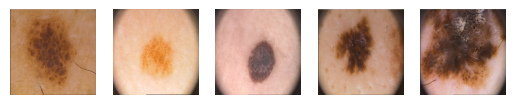

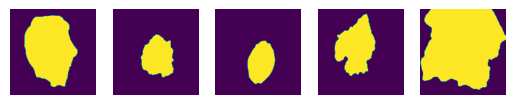

In [5]:
def plotn(n, data, only_mask=False):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(torch.permute(img, (1, 2, 0)))
        else:
            ax[i].imshow(img[0])
        ax1[i].imshow(mask[0])
        ax[i].axis('off')
        ax1[i].axis('off')
    plt.show()

plotn(5, train_dataset)

También necesitaremos DataLoaders para alimentar los datos a nuestra red neuronal.


In [6]:
train_dataloader = torch.utils.data.DataLoader(list(zip(train_dataset[0], train_dataset[1])), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(test_dataset[0], test_dataset[1])), batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

## SegNet

La arquitectura codificador-decodificador más simple se llama **SegNet**. Utiliza una CNN estándar con convoluciones y "poolings" en el codificador, y una CNN de deconvolución que incluye convoluciones y "upsamplings" en el decodificador. También se basa en la normalización por lotes para entrenar una red multicapa con éxito.

![SegNet](https://drive.google.com/uc?export=view&id=1sPmYy-jxWYUzgkDcOHKTJ2pKaarbZ4Jo)

> Imagen de este artículo: Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)


In [8]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)

        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)

        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

Debemos mencionar especialmente la función de pérdida que se utiliza para la segmentación. En los autoencoders clásicos, necesitamos medir la similitud entre dos imágenes, y podemos usar el error cuadrático medio para hacerlo. En la segmentación, cada píxel en la imagen de máscara objetivo representa el número de clase (codificado en one-hot a lo largo de la tercera dimensión), por lo que necesitamos utilizar funciones de pérdida específicas para la clasificación, como la pérdida de entropía cruzada, promediada sobre todos los píxeles. Si la máscara es binaria (como en nuestro ejemplo), utilizaremos **pérdida de entropía cruzada binaria** (BCE).


In [9]:
model = SegNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

El bucle de entrenamiento se define de la manera habitual:


In [10]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [12]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [00:25<00:00,  1.16it/s, train loss:=0.6, test loss:=0.578]


Para evaluar nuestro modelo, simplemente graficaremos las máscaras objetivo y las máscaras predichas para varias imágenes:


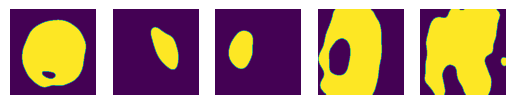

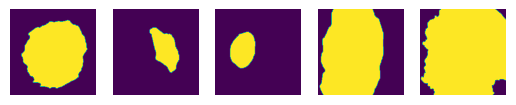

In [13]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)

También existen algunas métricas formales para evaluar el rendimiento, las cuales puedes leer [aquí](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2). La más fácil de entender es la **precisión de píxeles** (pixel accuracy), que es el porcentaje de píxeles clasificados correctamente.


## U-Net

La arquitectura de SegNet es muy natural, pero no es la más precisa. De hecho, primero aplicamos una arquitectura piramidal de CNN a la imagen original, lo que reduce la precisión espacial de las características de la imagen. Luego, al reconstruir la imagen, no podemos reconstruir correctamente las posiciones de los píxeles.

Esto nos lleva a la idea de las **conexiones de salto** entre las capas de convolución en el codificador y el decodificador. Esta arquitectura es muy común en la segmentación semántica y se llama **U-Net**. Las conexiones de salto en cada nivel de convolución ayudan a que la red no pierda información sobre las características de la entrada original en ese nivel.

Usaremos una arquitectura CNN bastante simple aquí, pero U-Net también puede utilizar un codificador más complejo para la extracción de características, como ResNet-50.

![UNet](https://drive.google.com/uc?export=view&id=1nTDe77ePgwDIArlhob2Md0nGhYqd4myL)

> Imagen del artículo: Ronneberger, Olaf, Philipp Fischer, y Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)




In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)

        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [15]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

In [16]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [00:40<00:00,  1.34s/it, train loss:=0.598, test loss:=0.57]


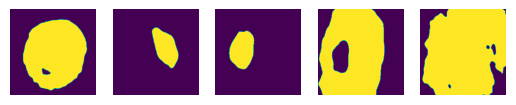

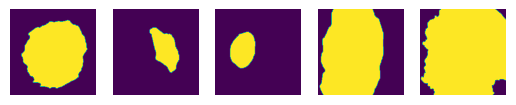

In [17]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)